In [2]:
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json
from PIL import Image

# define constants
max_sequence_len = 200
num_genres = 25
genres = ['Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western']

# load pre-trained models
text_model = load_model('/content/text_model.h5')
text_model._name = "text_model"
# create new output layer with 25 units
text_output = Dense(num_genres, activation='softmax')(text_model.layers[-2].output)
# create new model with new output layer
text_model = Model(inputs=text_model.input, outputs=text_output)

actor_model = load_model('/content/actor_model.h5')
actor_model._name = "actor_model"
actor_output = Dense(num_genres, activation='softmax')(actor_model.layers[-2].output)
# create new model with new output layer
actor_model = Model(inputs=actor_model.input, outputs=actor_output)

director_model = load_model('/content/director_model.h5')
director_model._name = "director_model"
director_output = Dense(num_genres, activation='softmax')(director_model.layers[-2].output)
# create new model with new output layer
director_model = Model(inputs=director_model.input, outputs=director_output)

writer_model = load_model('/content/writer_model.h5')
writer_model._name = "writer_model"
writer_output = Dense(num_genres, activation='softmax')(writer_model.layers[-2].output)
# create new model with new output layer
writer_model = Model(inputs=writer_model.input, outputs=writer_output)

poster_model = load_model('/content/my_image_model.h5')
poster_model._name = 'poster_model'
poster_output = Dense(num_genres, activation='softmax')(poster_model.layers[-2].output)
# create new model with new output layer
poster_model = Model(inputs=poster_model.input, outputs=poster_output)

# load tokenizer for text model
with open('/content/tokenizer.json') as f:
    data = json.load(f)
    text_tokenizer = tokenizer_from_json(data)

# define a function to preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = text_tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_sequence_len, padding='post')
    return text

# define a function to preprocess image data
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((400, 400))
    image = np.array(image)
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    return image

# define a function to preprocess names
def preprocess_names(names):
    names = [name.lower() for name in names]
    names = ' '.join(names)
    names = preprocess_text(names)
    names = names[:, -4:]
    return names


# define a function to make predictions
def predict_genre(poster_path, synopsis, director_names, writer_names, actor_names):
    # preprocess inputs
    poster = preprocess_image(poster_path)
    synopsis = preprocess_text(synopsis)
    director_names = preprocess_names(director_names)
    writer_names = preprocess_names(writer_names)
    actor_names = preprocess_names(actor_names)
    
    # make predictions
    poster_pred = poster_model.predict(poster)[0]
    synopsis_pred = text_model.predict(synopsis)[0]
    director_pred = director_model.predict(director_names)[0]
    writer_pred = writer_model.predict(writer_names)[0]
    actor_pred = actor_model.predict(actor_names)[0]
    
    # combine predictions using weights
    combined_pred = 0.8 * poster_pred + 0.3 * synopsis_pred + 0.1 * actor_pred + 0.1 * director_pred + 0.1 * writer_pred
    
    # get top three genres and their probabilities
    top_three_indices = np.argsort(combined_pred)[::-1][:3]
    top_three_probabilities = combined_pred[top_three_indices]

    # get genre names from indices
    top_three_genres = [genres[i] for i in top_three_indices]

    # print predictions
    print("Top 3 predicted genres:")
    for i in range(3):
        print(f"{top_three_genres[i]} ({top_three_probabilities[i]:.2f})")

    return top_three_genres, top_three_probabilities





In [3]:
poster_path = '/content/download.jpg'
synopsis = "Dominic Toretto (Vin Diesel) enjoys the adrenaline of street car racing and his fans treat him like a rock star. After a blazing encounter with the ruthless Johnny Tran, Dom decides to take Brian (Paul Walker), a newcomer to street racing, under his wing. Doms sister Mia sees something she likes in Brian, too. Trouble is, neither of them realize hes an undercover cop, and Dominic and his rival Johnny Tran are both the prime suspects in a case involving dirty money and big-rig hijacking"
director_names = ['Vin Diesel','Paul Walker']
writer_names = ['Neal H. Moritz']
actor_names = ['Vin Diesel'," Paul Walker","Michelle Rodriguez"]

top_genres, top_probabilities = predict_genre(poster_path, synopsis, director_names, writer_names, actor_names)

1/1 [==============================] - 1s 534ms/step


1/1 [==============================] - 1s 1s/step
Top 3 predicted genres:
Mystery (0.15)
Thriller (0.11)
Short (0.10)


In [ ]:
print('Top genres:', top_genres)
print('Probabilities:', top_probabilities)

Top genres: ['History', 'Action', 'Adventure']
Probabilities: [0.13347133 0.1248608  0.10049294]


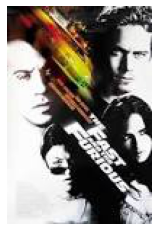

In [4]:
import matplotlib.pyplot as plt

# show image
img = plt.imread(poster_path)
plt.imshow(img)
plt.axis('off')
plt.show()
